In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib


In [2]:
# 归一化预处理
class Normalizer:
    def __init__(self, dataframe):
        """
        初始化类，接收一个DataFrame作为输入。
        """
        self.dataframe = dataframe
        self.scaler = MinMaxScaler()
        self.normalized_data = None
        self.scaler_params = None

    def get_normalization_params(self):
        """
        获取归一化参数（基于MinMaxScaler）。
        """
        # 拟合数据以获取归一化参数
        self.scaler.fit(self.dataframe)
        
        # 保存归一化参数
        self.scaler_params = {
            'data_min': self.scaler.data_min_,
            'data_max': self.scaler.data_max_
        }
        return self.scaler_params

    def preprocess(self, otherdata=None):
        """
        对数据进行归一化处理。
        使用类中的归一化参数，如果参数为空则抛出提示。

        参数:
        - otherdata: 可选参数，指定需要归一化的数据。如果未提供，则默认使用类中的dataframe。
        """
        if self.scaler_params is None:
            raise ValueError("归一化参数为空！请先调用 `get_normalization_params` 方法获取归一化参数。")
        
        # 如果未提供otherdata，则使用类中的dataframe
        if otherdata is None:
            otherdata = self.dataframe
        
        # 使用类中的归一化参数进行归一化
        data_min = self.scaler_params['data_min']
        data_max = self.scaler_params['data_max']
        normalized_data = (otherdata - data_min) / (data_max - data_min)
        
        # 将归一化后的数据转换回DataFrame
        normalized_df = pd.DataFrame(normalized_data, columns=otherdata.columns)
        return normalized_df

# 从 CSV 文件中读取数据并转换为 DataFrame
df_drop = pd.read_csv('df_drop.csv')
df = pd.read_csv('df.csv')

### 随机森林调参过程

In [3]:
# 随机森林默认参数
'''
rf = RandomForestClassifier(
    n_estimators=100,           # 树的数量

    criterion='gini',          # 分裂标准
    max_depth=None,              # 树的最大深度
    min_samples_split=2,       # 分裂内部节点所需的最小样本数
    min_samples_leaf=1,        # 叶节点所需的最小样本数
    max_features='auto',       # 寻找最佳分裂时考虑的特征数量

    random_state=68,           # 随机种子
    n_jobs=-1                  # 使用所有 CPU 核心
)
'''

"\nrf = RandomForestClassifier(\n    n_estimators=100,           # 树的数量\n\n    criterion='gini',          # 分裂标准\n    max_depth=None,              # 树的最大深度\n    min_samples_split=2,       # 分裂内部节点所需的最小样本数\n    min_samples_leaf=1,        # 叶节点所需的最小样本数\n    max_features='auto',       # 寻找最佳分裂时考虑的特征数量\n\n    random_state=68,           # 随机种子\n    n_jobs=-1                  # 使用所有 CPU 核心\n)\n"

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 假设 df_drop 是你的数据集
data = df_drop
df_X = df_drop.drop('Attrition', axis=1)
df_Y = df_drop['Attrition']

# 固定训练集和测试集的划分
xtrain, xtest, ytrain, ytest = train_test_split(df_X, df_Y, test_size=0.3, random_state=68)

# Normalizer 是自定义归一化类
normalize2 = Normalizer(xtrain)
normalize2.get_normalization_params()
xtrain = normalize2.preprocess()
xtest = normalize2.preprocess(xtest)

# 初始化随机森林模型，固定随机种子
rf = RandomForestClassifier(
    n_estimators=28,           # 树的数量
    max_depth=18,              # 树的最大深度
    min_samples_leaf=2,        # 叶节点所需的最小样本数
    min_samples_split=2,       # 分裂内部节点所需的最小样本数
    max_features=24,       # 寻找最佳分裂时考虑的特征数量
    criterion='gini',          # 分裂标准

    random_state=68,           # 随机种子
    n_jobs=-1                  # 使用所有 CPU 核心
)

# 训练模型
rf.fit(xtrain, ytrain)

# 评估模型
score = rf.score(xtest, ytest)

# 固定交叉验证的随机种子
kf = KFold(n_splits=5, shuffle=True, random_state=68)
cross_s = cross_val_score(rf, xtest, ytest, cv=kf).mean()

# 输出结果
print('rf:', score)
print('cv:', cross_s)

rf: 0.8939393939393939
cv: 0.8696969696969697


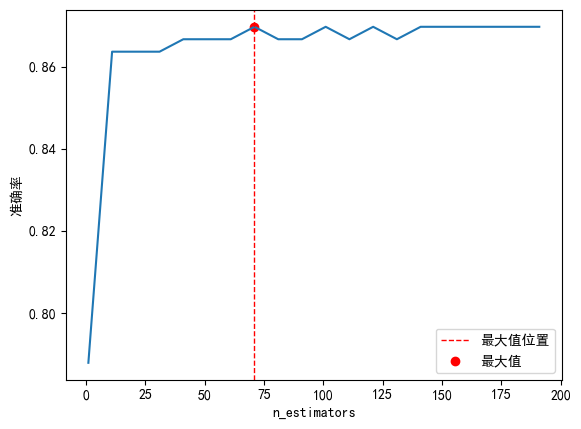

71 0.8696969696969697


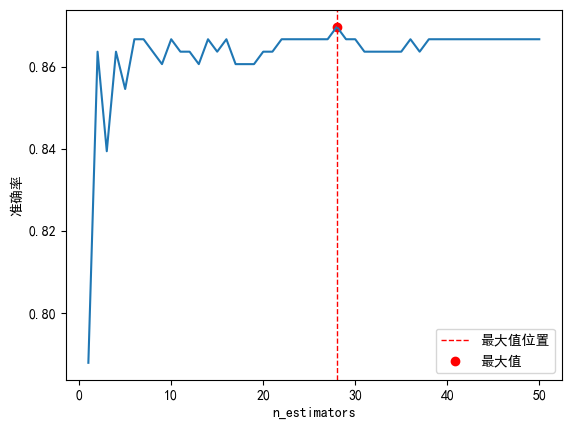

28 0.8696969696969697


In [5]:
#调参第一步：n_estimators
cross = []
for i  in range(0,200,10):
    rf = RandomForestClassifier(n_estimators=i+1, n_jobs=-1,random_state=68)
    cross_score = cross_val_score(rf, xtest, ytest, cv=kf).mean()
    cross.append(cross_score)
matplotlib.rcParams['font.sans-serif']=['SimHei'] 
plt.plot(range(1,201,10),cross)
max_index2 = (cross.index(max(cross))*10)+1
plt.axvline(x=max_index2, color='red', linestyle='--',linewidth=1, label='最大值位置')
plt.scatter(max_index2, max(cross), color='red', label='最大值')
plt.xlabel('n_estimators')
plt.ylabel('准确率')
plt.legend()
plt.show()
print((cross.index(max(cross))*10)+1,max(cross))

# n_estimators缩小范围
cross = []
for i  in range(0,50):
    rf = RandomForestClassifier(n_estimators=i+1, n_jobs=-1,random_state=68)
    cross_score = cross_val_score(rf, xtest, ytest, cv=kf).mean()
    cross.append(cross_score)
plt.plot(range(1,51),cross)
max_index2 = cross.index(max(cross))+1
plt.axvline(x=max_index2, color='red', linestyle='--', linewidth=1,label='最大值位置')
plt.scatter(max_index2, max(cross), color='red', label='最大值')
plt.xlabel('n_estimators')
plt.ylabel('准确率')
plt.legend()
plt.show()
print(cross.index(max(cross))+1,max(cross))

In [6]:
#调整max_depth
param_grid = {'max_depth' : np.arange(1,50,1)}
#一般根据数据大小进行尝试，像该数据集 可从1-10 或1-20开始
rf = RandomForestClassifier(n_estimators=28,random_state=68)
GS = GridSearchCV(rf,param_grid,cv=kf)
GS.fit(df_X,df_Y)
GS.best_score_
GS.best_params_



{'max_depth': 18}

In [7]:

#调整min_samples_leaf
param_grid = {'min_samples_leaf' : np.arange(1,1+50,1)}
#一般是从其最小值开始向上增加10或者20
# 面对高维度高样本数据，如果不放心，也可以直接+50，对于大型数据可能需要增加200-300
# 如果调整的时候发现准确率怎么都上不来，那可以放心大胆调一个很大的数据，大力限制模型的复杂度
rf = RandomForestClassifier(n_estimators=28,max_depth=18, random_state=68)
GS = GridSearchCV(rf,param_grid,cv=kf)
GS.fit(df_X,df_Y)
GS.best_score_
GS.best_params_

{'min_samples_leaf': 2}

In [8]:

#调整min_samples_split
param_grid = {'min_samples_split' : np.arange(2,2+50,1)}
#一般是从其最小值开始向上增加10或者20
# 面对高维度高样本数据，如果不放心，也可以直接+50，对于大型数据可能需要增加200-300
# 如果调整的时候发现准确率怎么都上不来，那可以放心大胆调一个很大的数据，大力限制模型的复杂度
rf = RandomForestClassifier(n_estimators=28,max_depth=18, min_samples_leaf=2, random_state=68)
GS = GridSearchCV(rf,param_grid,cv=kf)
GS.fit(df_X,df_Y)
GS.best_score_
GS.best_params_
 


{'min_samples_split': 2}

In [9]:
#调整max_features
param_grid = {'max_features' : np.arange(5,35,1)}
rf = RandomForestClassifier(n_estimators=28,max_depth=18, min_samples_leaf=2, random_state=68)
GS = GridSearchCV(rf,param_grid,cv=kf)
GS.fit(df_X,df_Y)
GS.best_score_
GS.best_params_


{'max_features': 24}

In [10]:
#调整criterion
param_grid = {'criterion' :['gini','entropy']}
#一般是从其最小值开始向上增加10或者20
# 面对高维度高样本数据，如果不放心，也可以直接+50，对于大型数据可能需要增加200-300
# 如果调整的时候发现准确率怎么都上不来，那可以放心大胆调一个很大的数据，大力限制模型的复杂度
rf = RandomForestClassifier(n_estimators=28,max_depth=18, min_samples_leaf=2, max_features=24, random_state=68)
GS = GridSearchCV(rf,param_grid,cv=kf)
GS.fit(df_X,df_Y)
GS.best_score_
GS.best_params_

{'criterion': 'gini'}